# MODEL IMPLEMENTATION
This notebook presents the implementation and training process of a machine learning model (XGBoost).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score,
    balanced_accuracy_score,
    roc_auc_score,
    matthews_corrcoef,
    confusion_matrix,
    hamming_loss)
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import joblib

In [ ]:
# Set Pandas to display all columns
pd.set_option('display.max_columns', None)

In [ ]:
DATA_FOLDER = "/content/drive/MyDrive/Structural Bioinfo PROJECT/datasets"
TARGETS = ['HBOND', 'IONIC', 'PICATION', 'PIHBOND', 'PIPISTACK', 'SSBOND', 'VDW']
PARAM_GRID = {
    'max_depth': [6, 8],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
    }
EXPERIMENTS = [
        ("origin_no_smote", "train_set_origin", "val_set_origin", "test_set_origin"),
        ("origin_smote", "train_set_origin_smote", "val_set_origin", "test_set_origin"),
        ("new_no_smote", "train_set_new", "val_set_new", "test_set_new"),
        ("new_smote", "train_set_new_smote", "val_set_new", "test_set_new"),
    ]

# Data Loading

In [ ]:
def load_tsv_as_df(folder, filename):
    if not filename.endswith('.tsv'):
        filename += '.tsv'
    path = os.path.join(folder, filename)
    df = pd.read_csv(path, sep='\t')
    return df

In [ ]:
def load_dataset(folder, train_file, val_file, test_file, target_cols):
    train_df = load_tsv_as_df(folder, train_file)
    val_df = load_tsv_as_df(folder, val_file)
    test_df = load_tsv_as_df(folder, test_file)
    X_train, y_train = train_df.drop(columns=target_cols), train_df[target_cols]
    X_val, y_val = val_df.drop(columns=target_cols), val_df[target_cols]
    X_test, y_test  = test_df.drop(columns=target_cols), test_df[target_cols]
    # Make sure same_chain is 0/1
    for df in [X_train, X_val, X_test]:
        df['same_chain'] = df['same_chain'].astype(int)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
def compute_sample_weights(y_train):
    class_weights = []
    for i in range(y_train.shape[1]):
        weights = compute_class_weight(
            class_weight='balanced', classes=np.array([0,1]), y=y_train.iloc[:,i]
        )
        class_weights.append(weights)
    return class_weights

# XGBoost

**XGBoost** is a *tree-based boosting algorithm* that combines multiple weak learners (decision trees) to build a strong predictive model.
We train a separate XGBoost classifier for each label using a *One-vs-All* approach, incorporating instance-level weights to account for class imbalance.

In [ ]:
def train_models(X_train, y_train, X_test, target_cols, class_weights, param_grid, output_folder, prefix):
    models, best_params, test_probs, test_preds = [], [], [], []
    for i, label in enumerate(target_cols):
        print(f"Training for label: {label}")
        y = y_train[label]
        sample_weight = np.where(y==1, class_weights[i][1], class_weights[i][0])
        xgb = XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            tree_method='hist',
            device='cuda'
        )
        grid = GridSearchCV(
            xgb, param_grid,
            scoring='f1_macro',
            cv=3,
            n_jobs=-1
        )
        grid.fit(X_train, y, sample_weight=sample_weight)
        best = grid.best_estimator_
        models.append(best)
        best_params.append({label: grid.best_params_})
        joblib.dump(best, os.path.join(output_folder, f"{label}.joblib"))

        probs = best.predict_proba(X_test)[:,1]
        preds = (probs >= 0.5).astype(int)
        test_probs.append(probs)
        test_preds.append(preds)
    return models, best_params, np.stack(test_probs, axis=1), np.stack(test_preds, axis=1)

## Performance Evaluation Metrics
In this section, the following metrics are computed for each label:
* **Accuracy** (both standard and unbalanced);

* **Precision** (both micro and macro);

* **Recall** (both micro and macro);

* **F1 score** (both micro and macro);

* **MCC** (Matthews Correlation Coefficient);

* **ROC AUC score** (macro version);

* **Confusion matrix**.

In [ ]:
def evaluate_all(y_true, y_prob, y_pred, target_cols, save_folder, prefix):
    os.makedirs(save_folder, exist_ok=True)
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'balanced_accuracy': np.mean([
            balanced_accuracy_score(y_true[:,i], y_pred[:,i])
            for i in range(y_true.shape[1])
        ]),
        'precision_micro': precision_score(y_true, y_pred, average='micro'),
        'recall_micro': recall_score(y_true, y_pred, average='micro'),
        'f1_micro': f1_score(y_true, y_pred, average='micro'),
        'precision_macro': precision_score(y_true, y_pred, average='macro'),
        'recall_macro': recall_score(y_true, y_pred, average='macro'),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'mcc': matthews_corrcoef(y_true.ravel(), y_pred.ravel()),
        'roc_auc_macro': roc_auc_score(y_true, y_prob, average='macro')
    }
    print("\n=== Overall Metrics ===")
    for k, v in metrics.items():
        print(f"{k}: {v: .4f}")
    per_label = {}
    for i, label in enumerate(target_cols):
        cm = confusion_matrix(y_true[:,i], y_pred[:,i])
        accuracy = accuracy_score(y_true[:,i], y_pred[:,i])
        balanced_accuracy = balanced_accuracy_score(y_true[:,i], y_pred[:,i])
        precision_micro = precision_score(y_true[:,i], y_pred[:,i], average='micro')
        recall_micro = recall_score(y_true[:,i], y_pred[:,i], average='micro')
        f1_micro = f1_score(y_true[:,i], y_pred[:,i], average='micro')
        precision_macro = precision_score(y_true[:,i], y_pred[:,i], average='macro')
        recall_macro = recall_score(y_true[:,i], y_pred[:,i], average='macro')
        f1_macro = f1_score(y_true[:,i], y_pred[:,i], average='macro')
        mcc = matthews_corrcoef(y_true[:,i].ravel(), y_pred[:,i].ravel())
        roc_auc_macro = roc_auc_score(y_true[:,i], y_prob[:,i], average='macro')
        per_label[label] = {
            'accuracy': accuracy,
            'balanced_accuracy': balanced_accuracy,
            'precision_micro': precision_micro,
            'recall_micro': recall_micro,
            'f1_micro': f1_micro,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'f1_macro': f1_macro,
            'mcc': mcc,
            'roc_auc_macro': roc_auc_macro,
            'conf_matrix': cm.tolist()
        }

        print(f"\n==={prefix} - {label} ===")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
        print(f"Precision Micro: {precision_micro:.4f}")
        print(f"Recall Micro: {recall_micro:.4f}")
        print(f"F1 Score Micro: {f1_micro:.4f}")
        print(f"Precision Macro: {precision_macro:.4f}")
        print(f"Recall Macro: {recall_macro:.4f}")
        print(f"F1 Score Macro: {f1_macro:.4f}")
        print(f"MCC: {mcc:.4f}")
        print(f"ROC AUC Macro: {roc_auc_macro:.4f}")

        plt.figure(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f"{label} Confusion Matrix")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(save_folder, f"cm_{label}.png"))
        plt.close()
    pd.DataFrame([metrics]).to_csv(os.path.join(save_folder, f"{prefix}_multilabel_metrics.csv"), index=False)
    pd.DataFrame(per_label).transpose().to_csv(os.path.join(save_folder, f"{prefix}_per_label_metrics.csv"))
    return metrics, per_label

## Experiments
A series of experiments was carried out to investigate the performance differences between different configurations. The changes considered included:
* The type of data used (original or integrated);

* The application of SMOTE (with or without).

In [ ]:
def run_experiment(exp_name, data_folder, output_folder, train_file, val_file, test_file, target_cols, param_grid):
    print(f"\n========== Experiment: {exp_name} ==========")
    os.makedirs(output_folder, exist_ok=True)
    X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(
        data_folder, train_file, val_file, test_file, target_cols
    )
    weights = compute_sample_weights(y_train)
    models, best_params, test_probs, test_preds = train_models(
        X_train, y_train, X_test, target_cols, weights, param_grid, output_folder, exp_name
    )
    metrics, per_label = evaluate_all(
        y_test.values, test_probs, test_preds, target_cols, output_folder, exp_name
    )
    pd.DataFrame(best_params).to_csv(os.path.join(output_folder, f"{exp_name}_best_params.csv"), index=False)
    return metrics, per_label


========== Experiment: origin_no_smote ==========
Training for label: HBOND
Training for label: IONIC
Training for label: PICATION
Training for label: PIHBOND
Training for label: PIPISTACK
Training for label: SSBOND
Training for label: VDW

=== Overall Metrics ===
accuracy:  0.4648
balanced_accuracy:  0.8398
precision_micro:  0.7190
recall_micro:  0.7070
f1_micro:  0.7130
precision_macro:  0.5141
recall_macro:  0.7915
f1_macro:  0.5811
mcc:  0.6486
roc_auc_macro:  0.9108

===origin_no_smote - HBOND ===
Accuracy: 0.7396
Balanced Accuracy: 0.7187
Precision Micro: 0.7396
Recall Micro: 0.7396
F1 Score Micro: 0.7396
Precision Macro: 0.6910
Recall Macro: 0.7187
F1 Score Macro: 0.6988
MCC: 0.4087
ROC AUC Macro: 0.7943


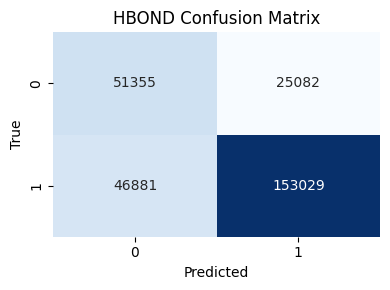


===origin_no_smote - IONIC ===
Accuracy: 0.9552
Balanced Accuracy: 0.9676
Precision Micro: 0.9552
Recall Micro: 0.9552
F1 Score Micro: 0.9552
Precision Macro: 0.6710
Recall Macro: 0.9676
F1 Score Macro: 0.7421
MCC: 0.5655
ROC AUC Macro: 0.9870


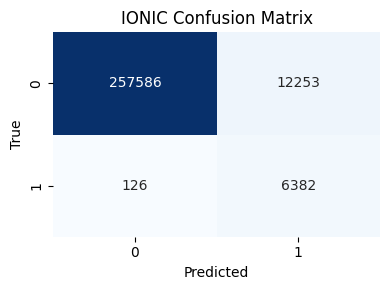


===origin_no_smote - PICATION ===
Accuracy: 0.9810
Balanced Accuracy: 0.9573
Precision Micro: 0.9810
Recall Micro: 0.9810
F1 Score Micro: 0.9810
Precision Macro: 0.6158
Recall Macro: 0.9573
F1 Score Macro: 0.6809
MCC: 0.4602
ROC AUC Macro: 0.9927


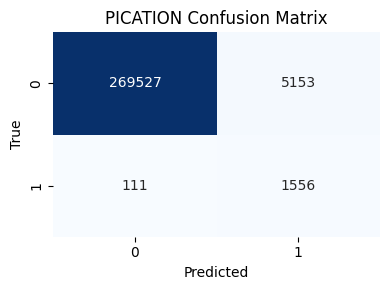


===origin_no_smote - PIHBOND ===
Accuracy: 0.9869
Balanced Accuracy: 0.6300
Precision Micro: 0.9869
Recall Micro: 0.9869
F1 Score Micro: 0.9869
Precision Macro: 0.5128
Recall Macro: 0.6300
F1 Score Macro: 0.5208
MCC: 0.0815
ROC AUC Macro: 0.9412


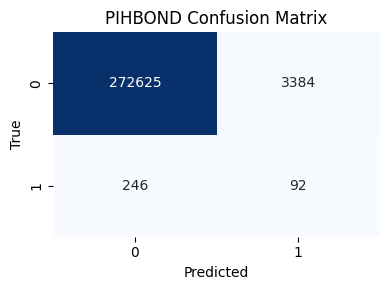


===origin_no_smote - PIPISTACK ===
Accuracy: 0.9905
Balanced Accuracy: 0.9946
Precision Micro: 0.9905
Recall Micro: 0.9905
F1 Score Micro: 0.9905
Precision Macro: 0.8735
Recall Macro: 0.9946
F1 Score Macro: 0.9250
MCC: 0.8596
ROC AUC Macro: 0.9971


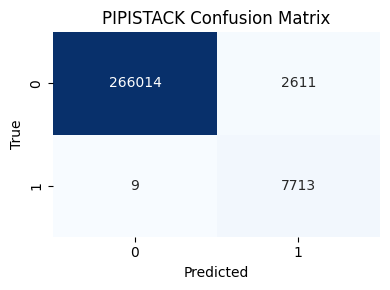


===origin_no_smote - SSBOND ===
Accuracy: 0.9995
Balanced Accuracy: 0.9986
Precision Micro: 0.9995
Recall Micro: 0.9995
F1 Score Micro: 0.9995
Precision Macro: 0.8836
Recall Macro: 0.9986
F1 Score Macro: 0.9336
MCC: 0.8747
ROC AUC Macro: 0.9999


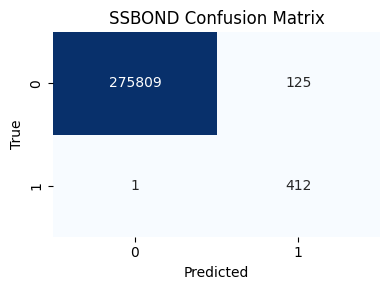


===origin_no_smote - VDW ===
Accuracy: 0.6115
Balanced Accuracy: 0.6118
Precision Micro: 0.6115
Recall Micro: 0.6115
F1 Score Micro: 0.6115
Precision Macro: 0.6119
Recall Macro: 0.6118
F1 Score Macro: 0.6114
MCC: 0.2237
ROC AUC Macro: 0.6633


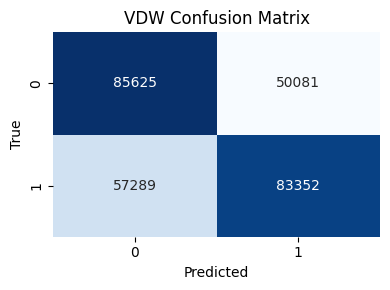


========== Experiment: origin_smote ==========
Training for label: HBOND
Training for label: IONIC
Training for label: PICATION
Training for label: PIHBOND
Training for label: PIPISTACK
Training for label: SSBOND
Training for label: VDW

=== Overall Metrics ===
accuracy:  0.3713
balanced_accuracy:  0.8174
precision_micro:  0.6617
recall_micro:  0.8547
f1_micro:  0.7459
precision_macro:  0.5001
recall_macro:  0.8233
f1_macro:  0.5958
mcc:  0.6881
roc_auc_macro:  0.9015

===origin_smote - HBOND ===
Accuracy: 0.7546
Balanced Accuracy: 0.6562
Precision Micro: 0.7546
Recall Micro: 0.7546
F1 Score Micro: 0.7546
Precision Macro: 0.6884
Recall Macro: 0.6562
F1 Score Macro: 0.6668
MCC: 0.3431
ROC AUC Macro: 0.7559


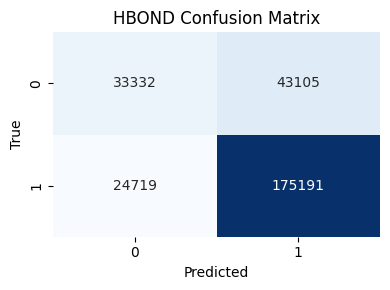


===origin_smote - IONIC ===
Accuracy: 0.9583
Balanced Accuracy: 0.9597
Precision Micro: 0.9583
Recall Micro: 0.9583
F1 Score Micro: 0.9583
Precision Macro: 0.6779
Recall Macro: 0.9597
F1 Score Macro: 0.7492
MCC: 0.5719
ROC AUC Macro: 0.9862


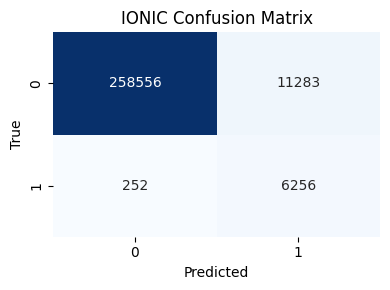


===origin_smote - PICATION ===
Accuracy: 0.9814
Balanced Accuracy: 0.9561
Precision Micro: 0.9814
Recall Micro: 0.9814
F1 Score Micro: 0.9814
Precision Macro: 0.6177
Recall Macro: 0.9561
F1 Score Macro: 0.6835
MCC: 0.4635
ROC AUC Macro: 0.9928


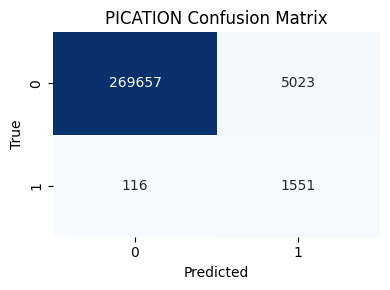


===origin_smote - PIHBOND ===
Accuracy: 0.9922
Balanced Accuracy: 0.5957
Precision Micro: 0.9922
Recall Micro: 0.9922
F1 Score Micro: 0.9922
Precision Macro: 0.5166
Recall Macro: 0.5957
F1 Score Macro: 0.5272
MCC: 0.0798
ROC AUC Macro: 0.9410


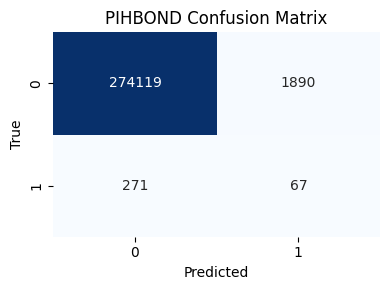


===origin_smote - PIPISTACK ===
Accuracy: 0.9904
Balanced Accuracy: 0.9951
Precision Micro: 0.9904
Recall Micro: 0.9904
F1 Score Micro: 0.9904
Precision Macro: 0.8726
Recall Macro: 0.9951
F1 Score Macro: 0.9245
MCC: 0.8590
ROC AUC Macro: 0.9964


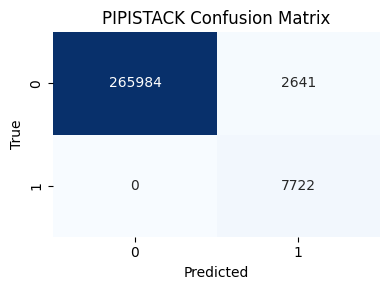


===origin_smote - SSBOND ===
Accuracy: 0.9995
Balanced Accuracy: 0.9925
Precision Micro: 0.9995
Recall Micro: 0.9995
F1 Score Micro: 0.9995
Precision Macro: 0.8861
Recall Macro: 0.9925
F1 Score Macro: 0.9329
MCC: 0.8722
ROC AUC Macro: 0.9999


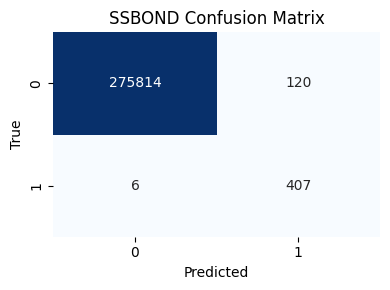


===origin_smote - VDW ===
Accuracy: 0.5709
Balanced Accuracy: 0.5665
Precision Micro: 0.5709
Recall Micro: 0.5709
F1 Score Micro: 0.5709
Precision Macro: 0.5878
Recall Macro: 0.5665
F1 Score Macro: 0.5411
MCC: 0.1528
ROC AUC Macro: 0.6385


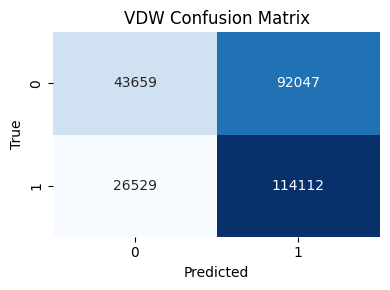


========== Experiment: new_no_smote ==========
Training for label: HBOND
Training for label: IONIC
Training for label: PICATION
Training for label: PIHBOND
Training for label: PIPISTACK
Training for label: SSBOND
Training for label: VDW

=== Overall Metrics ===
accuracy:  0.5818
balanced_accuracy:  0.8626
precision_micro:  0.8000
recall_micro:  0.7770
f1_micro:  0.7884
precision_macro:  0.5507
recall_macro:  0.7992
f1_macro:  0.6169
mcc:  0.7414
roc_auc_macro:  0.9470

===new_no_smote - HBOND ===
Accuracy: 0.8432
Balanced Accuracy: 0.8364
Precision Micro: 0.8432
Recall Micro: 0.8432
F1 Score Micro: 0.8432
Precision Macro: 0.8021
Recall Macro: 0.8364
F1 Score Macro: 0.8151
MCC: 0.6375
ROC AUC Macro: 0.9228


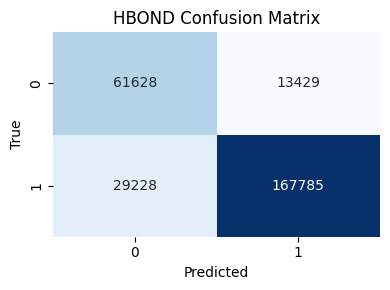


===new_no_smote - IONIC ===
Accuracy: 0.9606
Balanced Accuracy: 0.9636
Precision Micro: 0.9606
Recall Micro: 0.9606
F1 Score Micro: 0.9606
Precision Macro: 0.6847
Recall Macro: 0.9636
F1 Score Macro: 0.7574
MCC: 0.5853
ROC AUC Macro: 0.9897


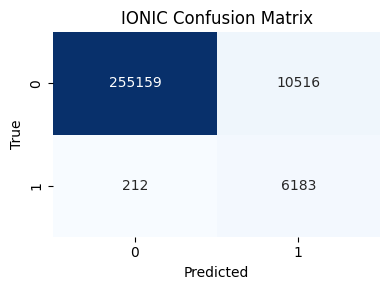


===new_no_smote - PICATION ===
Accuracy: 0.9843
Balanced Accuracy: 0.9414
Precision Micro: 0.9843
Recall Micro: 0.9843
F1 Score Micro: 0.9843
Precision Macro: 0.6374
Recall Macro: 0.9414
F1 Score Macro: 0.7068
MCC: 0.4925
ROC AUC Macro: 0.9939


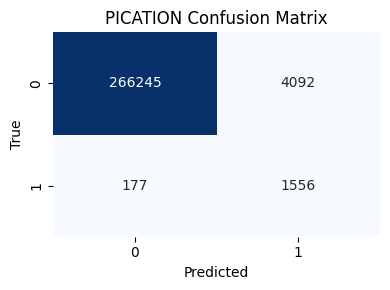


===new_no_smote - PIHBOND ===
Accuracy: 0.9914
Balanced Accuracy: 0.6219
Precision Micro: 0.9914
Recall Micro: 0.9914
F1 Score Micro: 0.9914
Precision Macro: 0.5199
Recall Macro: 0.6219
F1 Score Macro: 0.5329
MCC: 0.0984
ROC AUC Macro: 0.9503


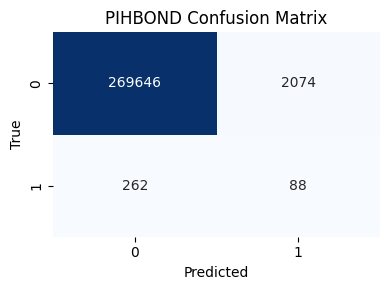


===new_no_smote - PIPISTACK ===
Accuracy: 0.9912
Balanced Accuracy: 0.9942
Precision Micro: 0.9912
Recall Micro: 0.9912
F1 Score Micro: 0.9912
Precision Macro: 0.8797
Recall Macro: 0.9942
F1 Score Macro: 0.9289
MCC: 0.8663
ROC AUC Macro: 0.9982


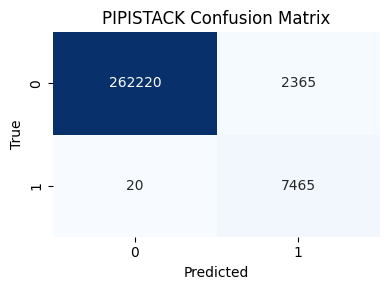


===new_no_smote - SSBOND ===
Accuracy: 0.9997
Balanced Accuracy: 0.9896
Precision Micro: 0.9997
Recall Micro: 0.9997
F1 Score Micro: 0.9997
Precision Macro: 0.8837
Recall Macro: 0.9896
F1 Score Macro: 0.9302
MCC: 0.8668
ROC AUC Macro: 0.9999


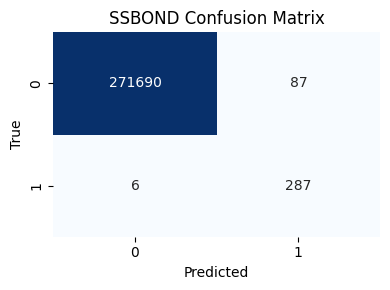


===new_no_smote - VDW ===
Accuracy: 0.6901
Balanced Accuracy: 0.6909
Precision Micro: 0.6901
Recall Micro: 0.6901
F1 Score Micro: 0.6901
Precision Macro: 0.6919
Recall Macro: 0.6909
F1 Score Macro: 0.6899
MCC: 0.3828
ROC AUC Macro: 0.7738


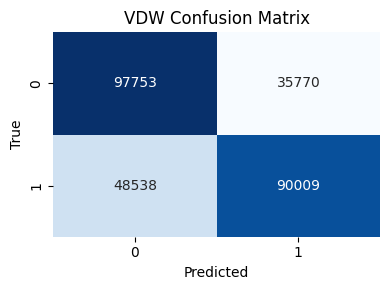


========== Experiment: new_smote ==========
Training for label: HBOND
Training for label: IONIC
Training for label: PICATION
Training for label: PIHBOND
Training for label: PIPISTACK
Training for label: SSBOND
Training for label: VDW

=== Overall Metrics ===
accuracy:  0.5379
balanced_accuracy:  0.8489
precision_micro:  0.7532
recall_micro:  0.8554
f1_micro:  0.8010
precision_macro:  0.5399
recall_macro:  0.8124
f1_macro:  0.6259
mcc:  0.7547
roc_auc_macro:  0.9427

===new_smote - HBOND ===
Accuracy: 0.8493
Balanced Accuracy: 0.8057
Precision Micro: 0.8493
Recall Micro: 0.8493
F1 Score Micro: 0.8493
Precision Macro: 0.8129
Recall Macro: 0.8057
F1 Score Macro: 0.8092
MCC: 0.6186
ROC AUC Macro: 0.9073


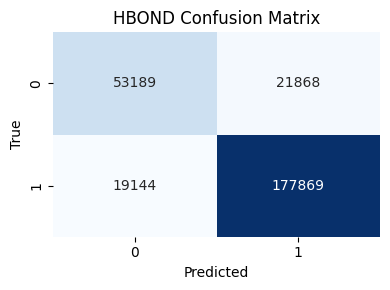


===new_smote - IONIC ===
Accuracy: 0.9646
Balanced Accuracy: 0.9563
Precision Micro: 0.9646
Recall Micro: 0.9646
F1 Score Micro: 0.9646
Precision Macro: 0.6965
Recall Macro: 0.9563
F1 Score Macro: 0.7693
MCC: 0.5989
ROC AUC Macro: 0.9897


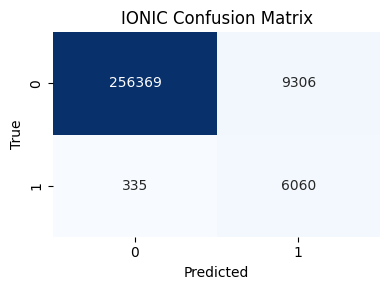


===new_smote - PICATION ===
Accuracy: 0.9850
Balanced Accuracy: 0.9314
Precision Micro: 0.9850
Recall Micro: 0.9850
F1 Score Micro: 0.9850
Precision Macro: 0.6404
Recall Macro: 0.9314
F1 Score Macro: 0.7094
MCC: 0.4923
ROC AUC Macro: 0.9939


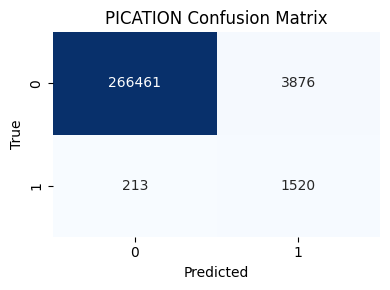


===new_smote - PIHBOND ===
Accuracy: 0.9938
Balanced Accuracy: 0.6002
Precision Micro: 0.9938
Recall Micro: 0.9938
F1 Score Micro: 0.9938
Precision Macro: 0.5236
Recall Macro: 0.6002
F1 Score Macro: 0.5376
MCC: 0.0974
ROC AUC Macro: 0.9512


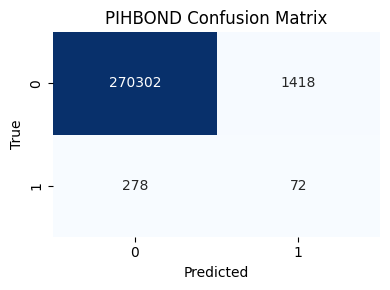


===new_smote - PIPISTACK ===
Accuracy: 0.9911
Balanced Accuracy: 0.9938
Precision Micro: 0.9911
Recall Micro: 0.9911
F1 Score Micro: 0.9911
Precision Macro: 0.8779
Recall Macro: 0.9938
F1 Score Macro: 0.9276
MCC: 0.8640
ROC AUC Macro: 0.9981


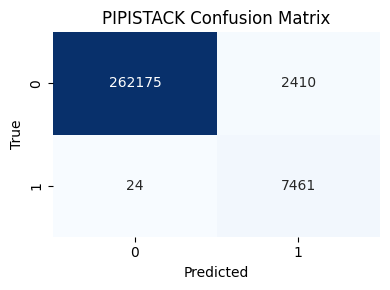


===new_smote - SSBOND ===
Accuracy: 0.9997
Balanced Accuracy: 0.9896
Precision Micro: 0.9997
Recall Micro: 0.9997
F1 Score Micro: 0.9997
Precision Macro: 0.8827
Recall Macro: 0.9896
F1 Score Macro: 0.9296
MCC: 0.8657
ROC AUC Macro: 0.9999


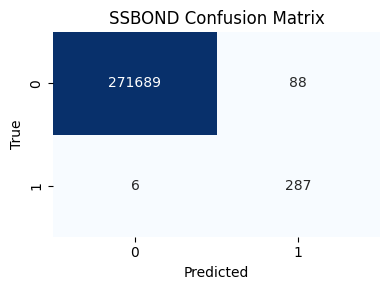


===new_smote - VDW ===
Accuracy: 0.6672
Balanced Accuracy: 0.6651
Precision Micro: 0.6672
Recall Micro: 0.6672
F1 Score Micro: 0.6672
Precision Macro: 0.6743
Recall Macro: 0.6651
F1 Score Macro: 0.6620
MCC: 0.3393
ROC AUC Macro: 0.7584


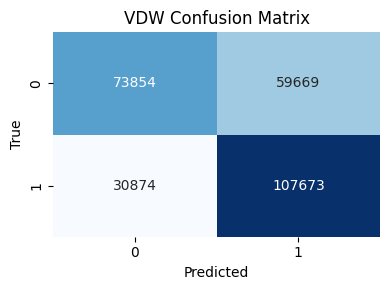

In [ ]:
all_results = {}
for name, train_file, val_file, test_file in EXPERIMENTS:
    out = os.path.join(DATA_FOLDER, f"results_{name}")
    all_results[name] = run_experiment(
        exp_name=name,
        data_folder=DATA_FOLDER,
        output_folder=out,
        train_file=train_file,
        val_file=val_file,
        test_file=test_file,
        target_cols=TARGETS,
        param_grid=PARAM_GRID
        )

# Feature Importance
Finally, we implemented *feature importance analysis* to identify which features contributed most to the model’s predictions. We considered all three importance types:

* **Gain**: how much each feature reduces the loss when used in a split. This is the most informative metric and reflects a feature’s overall impact on model performance;

* **Cover**: the number of data points affected by splits involving the feature, indicating how broadly the feature is applied;

* **Weight**: how often a feature is used across all trees. This helps highlight features that are frequently relied upon.

This comprehensive approach helps us better understand the model’s behavior and provides valuable insights into the factors driving its decisions.

In [ ]:
def extract_feature_importance(model_dir, target_cols, top_k=20, importance_type='gain', save_plots=True):
    all_importances = {}
    for label in target_cols:
        model_path = os.path.join(model_dir, f"{label}.joblib")
        model = joblib.load(model_path)

        booster = model.get_booster()
        importance_dict = booster.get_score(importance_type=importance_type)

        # Convert to DataFrame
        imp_df = pd.DataFrame([
            {"feature": feature, "importance": score}
            for feature, score in importance_dict.items()
        ])
        imp_df = imp_df.sort_values(by="importance", ascending=False).reset_index(drop=True)
        all_importances[label] = imp_df

        # Plot
        if save_plots and not imp_df.empty:
            plt.figure(figsize=(8, max(4, top_k * 0.4)))
            sns.barplot(data=imp_df.head(top_k), x="importance", y="feature", palette="viridis")
            plt.title(f"Top {top_k} Features for {label} ({importance_type})")
            plt.tight_layout()
            os.makedirs(os.path.join(model_dir, "feature_importance_plots"), exist_ok=True)
            plt.savefig(os.path.join(model_dir, "feature_importance_plots", f"{label}_importance_{importance_type}.png"))
            plt.close()

    return all_importances

In [ ]:
model_dir_origin = [f"{DATA_FOLDER}/results_origin_no_smote", f"{DATA_FOLDER}/results_origin_smote"]
model_dir_new = [f"{DATA_FOLDER}/results_new_no_smote", f"{DATA_FOLDER}/results_new_smote"]

In [ ]:
for model_dir in model_dir_origin:
    for imp_type in ['gain', 'weight', 'cover']:
        feature_importance_results = extract_feature_importance(
            model_dir=model_dir,
            target_cols=TARGETS,
            top_k=20,
            importance_type=imp_type
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:15:40] WARNING: /workspace/src/gbm/gbtree.cc:388: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:15:40] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:15:40] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/tmp/ipython-input-30-736142118.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df.head(top_k), x="importance", y="feature", palette="viridis")
/usr/local/lib/python3.11/dist-packages/xgboost/co

In [ ]:
for model_dir in model_dir_new:
    for imp_type in ['gain', 'weight', 'cover']:
        feature_importance_results = extract_feature_importance(
            model_dir=model_dir,
            target_cols=TARGETS,
            top_k=20,
            importance_type=imp_type
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:16:07] WARNING: /workspace/src/gbm/gbtree.cc:388: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:16:07] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:16:07] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/tmp/ipython-input-30-736142118.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df.head(top_k), x="importance", y="feature", palette="viridis")
/usr/local/lib/python3.11/dist-packages/xgboost/co